quandl housing api:  
https://www.quandl.com/blog/api-for-housing-data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor as rf

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT

sns.set_context("paper")

In [2]:
hoods = ut.load_hoods()
cities = ut.load_cities()
counties = ut.load_counties()
states = ut.load_states()
indicators = ut.load_indicators()

In [3]:
px_us = ut.load_quandl_data('regions','A').ix[:,0]
px_ca = ut.load_quandl_data('states','A').ix[:,0]
px_h = ut.load_quandl_data('hoods','A')

px_h = (px_h
        .fillna(method='bfill', limit=3)
        .fillna(method='ffill', limit=3)
        .dropna(axis=1))

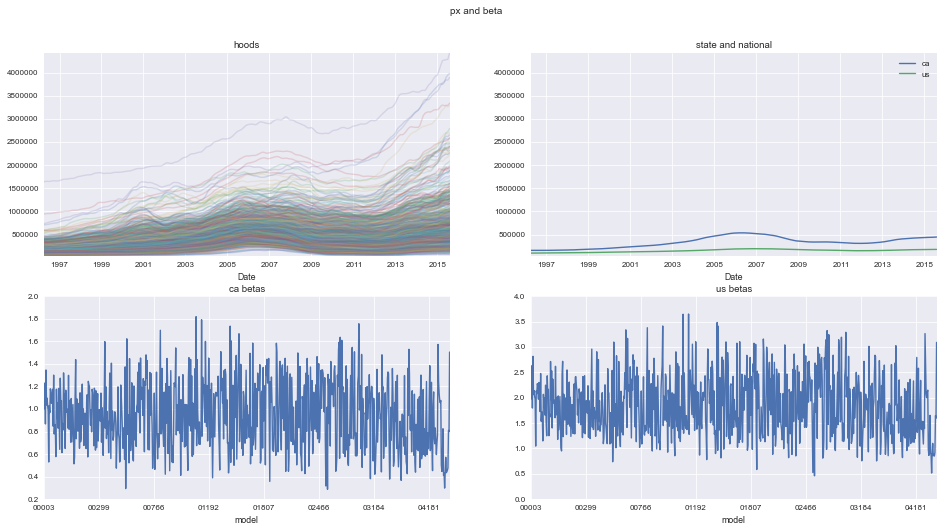

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT*2))
fig.suptitle('px and beta')

px_h.ix[:,:].plot(alpha=.2, legend=False, title='hoods', ax=axes[0,0])
df = pd.DataFrame({'us': px_us, 'ca': px_ca})
df.plot(title='state and national', ax=axes[0,1])

ymax = max(df.max().max(), px_h.max().max())
ymin = min(df.min().min(), px_h.min().min())
axes[0,0].set_ylim([ymin,ymax])
axes[0,1].set_ylim([ymin,ymax])

betas_ca = ut.get_betas(px_h, px_ca)
betas_ca.plot(title='ca betas', ax=axes[1,0])
betas_us = ut.get_betas(px_h, px_us)
betas_us.plot(title='us betas', ax=axes[1,1])

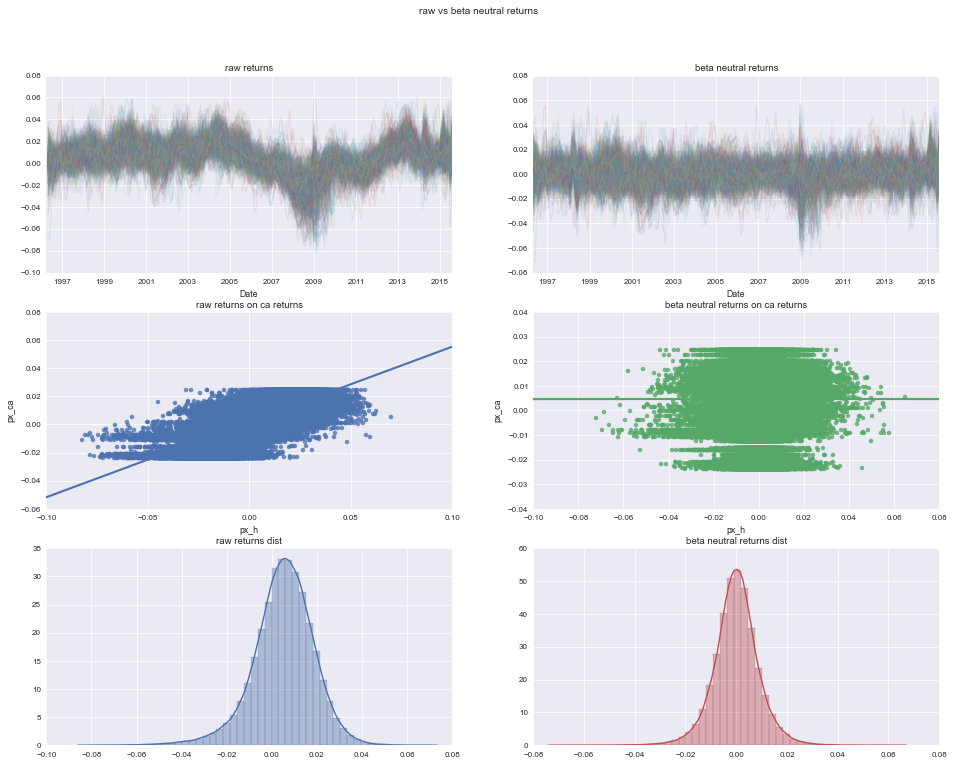

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(FIG_WIDTH*2, FIG_HEIGHT*3))
fig.suptitle('raw vs beta neutral returns')

px_h_r_nt = ut.get_beta_neutral_returns(px_h.pct_change().dropna(), px_ca.pct_change().dropna())
px_ca_r_df = pd.DataFrame({c: px_ca.pct_change().values for c in px_h.columns}, index=px_ca.index)

px_h.pct_change().plot(legend=False, alpha=.1, ax=axes[0,0], title='raw returns')
px_h_r_nt.plot(legend=False, alpha=.1, ax=axes[0,1], title='beta neutral returns')

a = (ut.stack_and_align([px_h.pct_change(), px_ca_r_df], cols=['px_h', 'px_ca']).dropna())
sns.regplot(x='px_h', y='px_ca', data=a, ax=axes[1,0]).set_title('raw returns on ca returns')

a = (ut.stack_and_align([px_h_r_nt, px_ca_r_df], cols=['px_h', 'px_ca']).dropna())
sns.regplot(x='px_h', y='px_ca', data=a, ax=axes[1,1]).set_title('beta neutral returns on ca returns')

sns.distplot(px_h.pct_change().stack(), ax=axes[2,0]).set_title('raw returns dist')
sns.distplot(px_h_r_nt.stack(), ax=axes[2,1]).set_title('beta neutral returns dist')

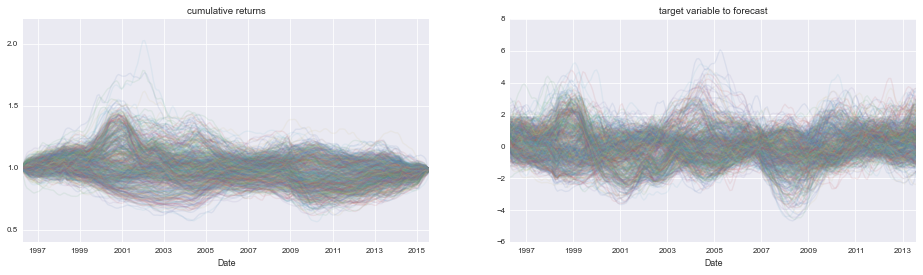

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
cum_ret = ut.get_cum_return(px_h_r_nt) + 1.
cum_ret.plot(legend=False, alpha=.1, ax=axes[0], title='cumulative returns')
tar = ut.load_target()
tar.plot(legend=False, alpha=.1, ax=axes[1], title='target variable to forecast')

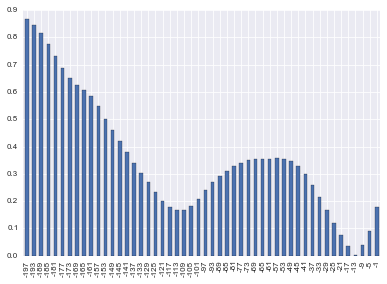

In [7]:
p = pd.Panel({i: (cum_ret / cum_ret.shift(i)).dropna(how='all') for i in range(1,200,4)})
df = ut.stack_and_align([p[i] for i in p.items] + [tar,],
                        cols=list(p.items) + ['tar',])

corr = {}
clf = lm.LinearRegression(fit_intercept=True)
for i in df.columns[:-1]:
    
    try:
        d = df[[i, 'tar']].dropna()
        clf.fit(d[[i]], d['tar'])
        corr[-i] = math.sqrt(clf.score(d[[i]], d['tar']))
    except:
        pass

corr = pd.Series(corr)
corr.plot(kind='bar')

plot lead lag correlation  
calc momentum score linear model  
calc momentum score tree model  

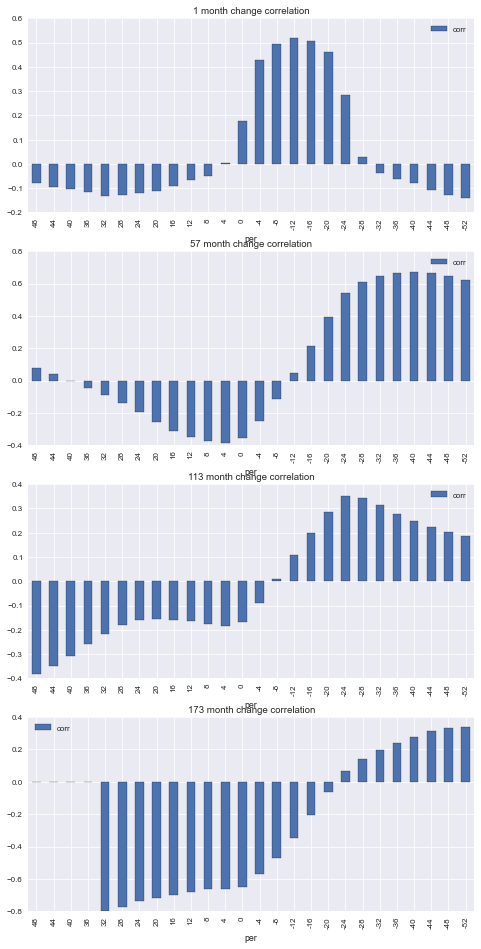

In [8]:
pers = (1,57,113,173)
fig, axes = plt.subplots(nrows=len(pers), figsize=(FIG_WIDTH, FIG_HEIGHT*len(pers)))
for i in range(len(pers)):
    (ut.lead_lag_corr(df[pers[i]].unstack(), df['tar'].unstack())
    .plot(kind='bar', title='{0} month change correlation'.format(pers[i]), ax=axes[i]))

In [9]:
# fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
# rand_cols = random.sample(px_h.columns, 15)
# px_h[rand_cols].plot(ax=axes[0], title='raw px')
# px_h = ut.kalman_ma(px_h)
# px_h[rand_cols].plot(ax=axes[1], title='smoothed px')

In [276]:
df_sub = df[['tar', 1, 33, 57, 89, 113]]
df_sub = pd.concat([df_sub, px_ca_r_df.stack()], axis=1)
df_sub.rename(columns={0: 'ca'}, inplace=True)
df_sub.dropna(inplace=True)

In [281]:
X = df_sub.ix[:,1:]
X = ut.get_z_scores(X)
y = df_sub['tar']

clf = rf(n_estimators=50, oob_score=True)
clf.fit(X, y)
print clf.score(X, y)
print clf.oob_score_

0.95164112051
0.653733471217


In [293]:
X = df_sub.ix[:,1:]
for i in (i for i in X.columns if i != 'ca'):
    X[i] = ut.kalman_ma(X[i].unstack()).stack()
X = ut.get_z_scores(X)
y = df_sub['tar']

clf = rf(n_estimators=50, oob_score=True)
clf.fit(X, y)
print clf.score(X, y)
print clf.oob_score_

0.974401218746
0.815368525768


/Users/ryanchouck/dev/re/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


False

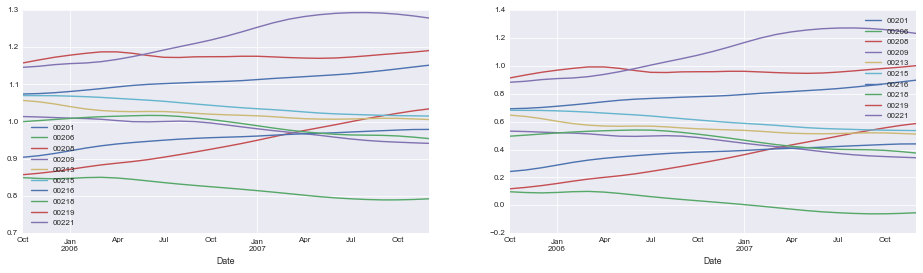

In [320]:
fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
per = 33
count = 80
df_sub[per].unstack().ix[datetime.date(2005,1,1):datetime.date(2008,1,1),count-10:count].plot(ax=axes[0])
X[per].unstack().ix[datetime.date(2005,1,1):datetime.date(2008,1,1),count-10:count].plot(ax=axes[1])
df_sub[per].unstack().ix[datetime.date(2005,1,1):datetime.date(2008,1,1),count-10:count].equals(X[per].unstack().ix[datetime.date(2005,1,1):datetime.date(2008,1,1),:count])

In [16]:
df = ut.stack_and_align(mom, fwd_ret_ts, cols=['mom', 'fwd'])

In [17]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(df[['mom']], df['fwd'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
pred_score = pd.DataFrame(clf.predict(df[['mom']]), index=df.index, columns=['pred_score'])
pred_value = ut.z_score_to_value(df['mom'].unstack(), fwd_ret).stack()
pred_value.name = 'pred_value'
d = ut.stack_and_align([df['mom'], df['fwd'], pred_score, pred_value])
d['pred_err'] = df['fwd'] - pred_value
a = d[['fwd', 'pred_value']].applymap(lambda x: 1 if x > 0 else -1)
d['dir_accurate'] = a['fwd'] == a['pred_value']

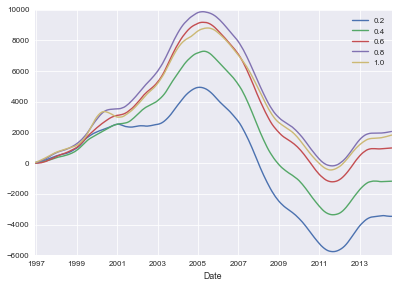

In [139]:
ut.gen_quintile_data(d, 'pred_score', 'fwd').cumsum().plot()

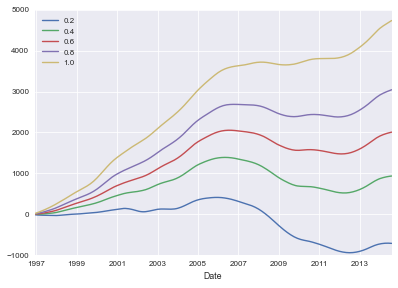

In [140]:
ut.gen_quintile_data(d, 'pred_score', 'pred_value').cumsum().plot()

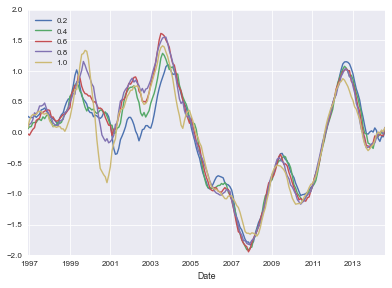

In [141]:
ut.gen_quintile_data(d, 'pred_score', 'pred_err', agg='mean').plot()

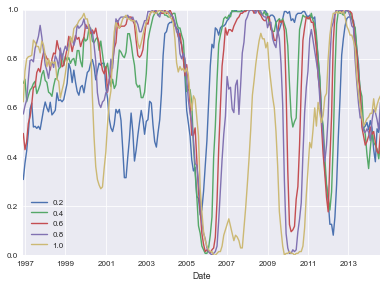

In [150]:
ut.gen_quintile_data(d, 'pred_score', 'dir_accurate', agg='mean').plot()

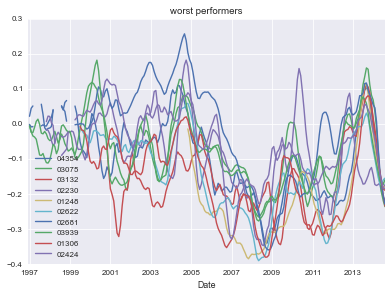

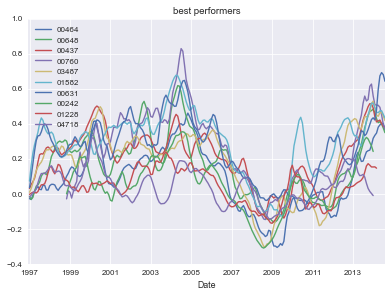

In [175]:
c = ut.get_cum_return(d['pred_value'].unstack(), outlier_threshold=10)
assets_ranked = c.tail(5).mean().order().index
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')

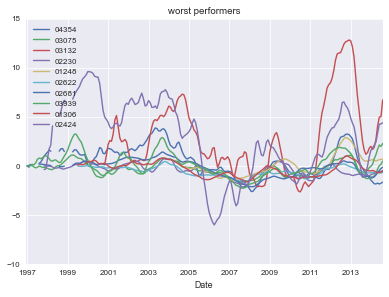

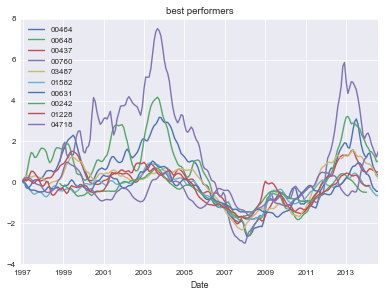

In [176]:
c = ut.get_cum_return(d['fwd'].unstack(), outlier_threshold=10)
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')

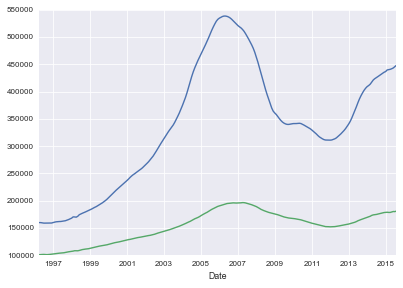

In [16]:
px_ca.plot()
px_us.plot()